In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import wordnet
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


# load data

In [2]:
train = pd.read_csv("liar/train.tsv")
val = pd.read_csv("liar/valid.tsv")
train['test']=0
val['test']=0

train.loc[train['category'] == 'TRUE', 'test'] = 1
train.loc[train['category'] == 'mostly-true', 'test'] = 1

val.loc[val['category'] == 'TRUE', 'test'] = 1
val.loc[val['category'] == 'mostly-true', 'test'] = 1

df=train


# data Processing

In [3]:
stopW = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopW.update(punctuation)

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def remove_noise(text):
    return re.sub(r'http\S+\[[^]]*\]', '', text)
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopW:
            final_text.append(i.strip())
    return " ".join(final_text)
#Remove noise
def denoise_text(text):
    text = strip(text)
    text = remove_noise(text)
    text = remove_stopwords(text)
    return text

df['text']=df['text'].apply(denoise_text)
val['text']=val['text'].apply(denoise_text)


In [4]:
x_train = df.text
y_train = df.test
x_test = val.text
y_test = val.test

In [5]:
max_f = 10000
max_len = 300

# word embeding with glove

In [6]:
tokenizer = text.Tokenizer(num_words=max_f)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)

In [7]:
tokenizedTest = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenizedTest, maxlen=max_len)

In [8]:
EMBEDDING = 'kaggle/input/glove-twitter/glove.twitter.27B.50d.txt'
def get_coefficients(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefficients(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_f, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_f: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 

        embedding_matrix[i] = embedding_vector

/home/exx/.conda/envs/troni-py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# AutoSK model

In [9]:
import autosklearn.classification
!rm -r /tmp/autosklearn_classification_example_tmp1
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=6000,
    per_run_time_limit=300,
    tmp_folder='/tmp/autosklearn_classification_example_tmp1',
    memory_limit=27000,
    ensemble_size=10,
#    include={'extra_tress'},
)

rm: cannot remove ‘/tmp/autosklearn_classification_example_tmp1’: No such file or directory


In [10]:
automl.fit(x_train, y_train)


[WARNING] [2021-11-26 11:24:03,250:Client-AutoML(1):69c3cc15-4eee-11ec-94f2-bb822b0a4874] Unknown dtype for X: int32, assuming it takes 8 bit/number
[WARNING] [2021-11-26 11:24:13,212:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2021-11-26 11:24:27,446:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 2. Number of dummy models: 1
[WARNING] [2021-11-26 11:25:00,593:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 3. Number of dummy models: 1
[WARNING] [2021-11-26 11:25:03,210:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 3. Number of dummy models: 1
[WARNING] [2021-11-26 11:25:08,654:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models

AutoSklearnClassifier(ensemble_size=10, memory_limit=27000,
                      per_run_time_limit=300, time_left_for_this_task=6000,
                      tmp_folder='/tmp/autosklearn_classification_example_tmp1')

In [11]:
import sklearn
y_hat = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

Accuracy score 0.6791277258566978


In [12]:
print(automl.show_models())


[(1.000000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'select_rates_classification', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 13, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median', 'data_preprocessor:featu

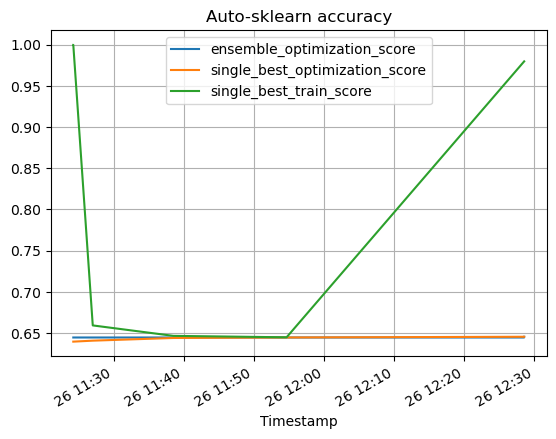

In [13]:
import matplotlib.pyplot as plt

poT = automl.performance_over_time_
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy',
    grid=True,
)
plt.show()